In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")
from fbprophet import Prophet

df=pd.read_csv('bangalore_rain2.csv')
df.Date = pd.to_datetime(df.Date)
df = df.set_index("Date")
rain = df['Rain(mm)']
df.drop(labels=['Rain(mm)'], axis=1,inplace = True)
df.insert(0, 'Rain(mm)', rain)
df.head()

Importing plotly failed. Interactive plots will not work.


,Rain(mm),Atm_Pressure(mb),Cloud_Density(%),Humidity(%),Max_Temp(°c),Min_Temp(°c),Wind_Direction,Wind_Speed(Km/h)
Date,,,,,,,,
2018-01-01,0.0,1011.0,11.0,56.0,28.0,17.0,SSE,5.0
2018-01-02,0.0,1011.0,10.0,54.0,28.0,17.0,S,7.0
2018-01-03,0.2,1012.0,18.0,58.0,27.0,19.0,ESE,8.0
2018-01-04,0.0,1013.0,14.0,58.0,27.0,17.0,ENE,12.0
2018-01-05,0.0,1013.0,10.0,53.0,27.0,17.0,E,11.0


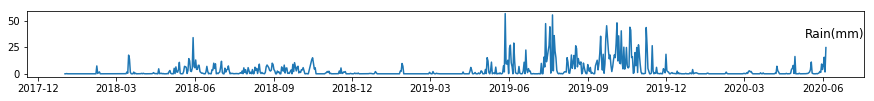

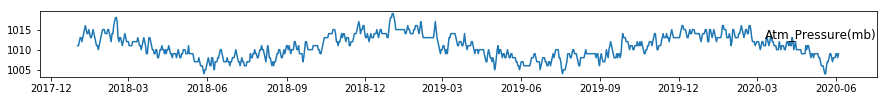

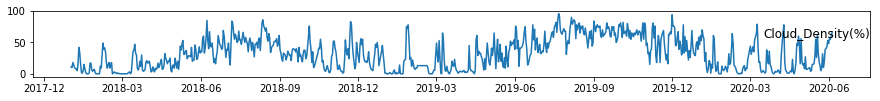

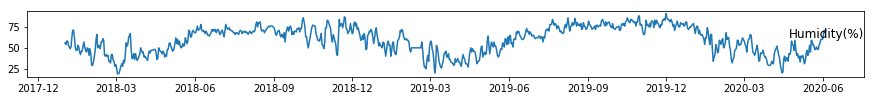

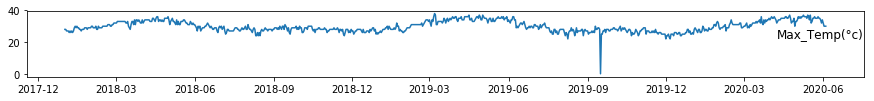

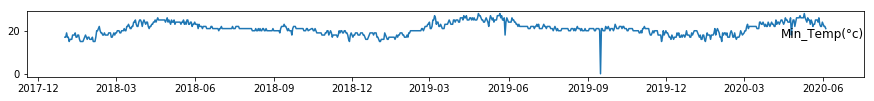

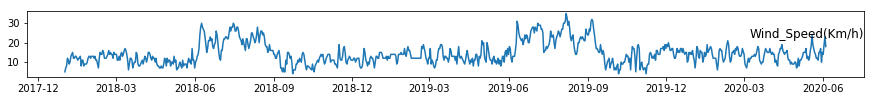

In [2]:
# plot each column
values=df.values
groups = [0, 1, 2, 3, 4, 5, 7]
i = 1
for group in groups:
    plt.figure(figsize=(15, 10))
    plt.subplot(len(groups), 1, i)
    plt.plot(df.index,values[:, group])
    plt.title(df.columns[group], y=0.5, loc='right')
    i += 1
plt.show()

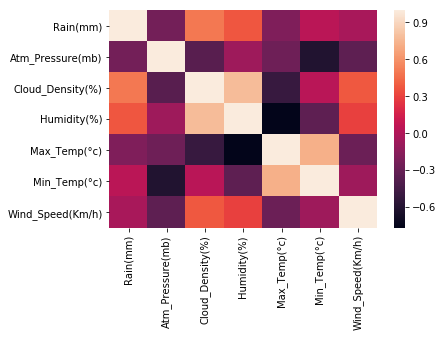

In [3]:
#Correlation Matrix
import seaborn as sns
corr = df.corr()
sns.heatmap(corr, 
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values)

In [4]:
#Drop the categorical Variable
df_final=df.drop('Wind_Direction',axis=1)
df_final.head()

,Rain(mm),Atm_Pressure(mb),Cloud_Density(%),Humidity(%),Max_Temp(°c),Min_Temp(°c),Wind_Speed(Km/h)
Date,,,,,,,
2018-01-01,0.0,1011.0,11.0,56.0,28.0,17.0,5.0
2018-01-02,0.0,1011.0,10.0,54.0,28.0,17.0,7.0
2018-01-03,0.2,1012.0,18.0,58.0,27.0,19.0,8.0
2018-01-04,0.0,1013.0,14.0,58.0,27.0,17.0,12.0
2018-01-05,0.0,1013.0,10.0,53.0,27.0,17.0,11.0


In [5]:
#Prepare data into fbProphet format
df_prophet=pd.DataFrame()
df_prophet['ds']=df_final.index
df_prophet['y']=df_final['Rain(mm)'].values
for i in range(1,len(df_final.columns)):
    df_prophet[df_final.columns[i]]=df_final[df_final.columns[i]].values

#add predictor value as regressor    
df_prophet.tail()

,ds,y,Atm_Pressure(mb),Cloud_Density(%),Humidity(%),Max_Temp(°c),Min_Temp(°c),Wind_Speed(Km/h)
877,2020-05-31,4.0,1008.0,48.0,60.0,34.0,24.0,15.0
878,2020-06-01,7.3,1009.0,56.0,65.0,32.0,23.0,14.0
879,2020-06-02,15.6,1009.0,55.0,71.0,30.0,22.0,19.0
880,2020-06-03,1.7,1008.0,60.0,69.0,30.0,22.0,23.0
881,2020-06-04,24.7,1009.0,66.0,71.0,30.0,21.0,18.0


In [6]:
def series_to_seq(data, n_in=1, n_out=1, dropnan=True):
	n_vars = 1 if type(data) is list else data.shape[1]
	df = pd.DataFrame(data)
	cols, names = list(), list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
		names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
		if i == 0:
			names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	# put it all together
	agg = pd.concat(cols, axis=1)
	agg.columns = names
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg

In [7]:
#create lag steps
lag_steps=8
df_lag=series_to_seq(df_prophet.iloc[:,2:],lag_steps)

In [8]:
#remove dates with nan values to concat
end=df_prophet.shape[0]-df_lag.shape[0]
df_lag = df_lag.set_index(df_prophet.index[:-end])
df_prophet_lagged = pd.concat([df_prophet.iloc[:-end,0:2], df_lag], axis=1)
df_prophet_lagged.tail()

,ds,y,var1(t-8),var2(t-8),var3(t-8),var4(t-8),var5(t-8),var6(t-8),var1(t-7),var2(t-7),...,var3(t-1),var4(t-1),var5(t-1),var6(t-1),var1(t),var2(t),var3(t),var4(t),var5(t),var6(t)
869,2020-05-23,0.0,1007.0,10.0,48.0,35.0,25.0,14.0,1008.0,32.0,...,60.0,32.0,22.0,10.0,1008.0,48.0,60.0,34.0,24.0,15.0
870,2020-05-24,0.2,1008.0,32.0,51.0,35.0,25.0,12.0,1009.0,10.0,...,60.0,34.0,24.0,15.0,1009.0,56.0,65.0,32.0,23.0,14.0
871,2020-05-25,0.0,1009.0,10.0,49.0,35.0,25.0,12.0,1009.0,19.0,...,65.0,32.0,23.0,14.0,1009.0,55.0,71.0,30.0,22.0,19.0
872,2020-05-26,0.4,1009.0,19.0,48.0,36.0,24.0,11.0,1008.0,39.0,...,71.0,30.0,22.0,19.0,1008.0,60.0,69.0,30.0,22.0,23.0
873,2020-05-27,0.8,1008.0,39.0,53.0,35.0,26.0,15.0,1007.0,40.0,...,69.0,30.0,22.0,23.0,1009.0,66.0,71.0,30.0,21.0,18.0


In [9]:
#Split the data to train and test
prophet_train, prophet_test=df_prophet_lagged[:-350], df_prophet_lagged[-350:]

In [10]:
prophet = Prophet(changepoint_prior_scale=1.0, changepoint_range = 1.0,
                  interval_width=0.95, mcmc_samples=15,
                  daily_seasonality=True, weekly_seasonality=True, 
                  yearly_seasonality=True)

prophet.add_seasonality(name='monthly', period=30.5, fourier_order=4,mode='additive')

#except 'ds' & 'y' add all other columns as regressor
for i in range(2,len(df_prophet_lagged.columns)):
       prophet.add_regressor(df_prophet_lagged.columns[i])



prophet.fit(prophet_train)
forecast=prophet.predict(prophet_test.drop(columns="y"))

In [11]:
forecast.tail()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,daily,...,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
345,2020-05-23,-6.519607,-51.740915,54.614558,-46.628587,39.900973,4.750412,-1.463193,18.017218,3.702427,...,-0.023042,-3.076163,2.732404,1.266302,-10.046198,10.078999,0.0,0.0,0.0,-1.769195
346,2020-05-24,-6.527555,-45.302469,59.662555,-46.788064,39.998905,6.547096,0.719491,10.898785,3.702427,...,-1.583391,-3.507091,-0.289221,1.155747,-9.766502,10.577885,0.0,0.0,0.0,0.019541
347,2020-05-25,-6.535503,-53.885002,56.704494,-46.946420,40.096838,1.513848,-9.304009,15.249208,3.702427,...,0.142243,-0.623559,0.542279,1.024959,-9.463931,10.976872,0.0,0.0,0.0,-5.021655
348,2020-05-26,-6.543451,-41.936468,58.185735,-47.104776,40.190405,11.095046,4.591782,23.630079,3.702427,...,0.134693,-1.658103,2.217925,0.876194,-9.140839,11.266180,0.0,0.0,0.0,4.551595
349,2020-05-27,-6.551399,-54.212349,46.053014,-47.263132,40.268993,5.620519,-8.477357,19.556951,3.702427,...,0.376798,-0.972712,2.605993,0.711999,-8.799587,11.437859,0.0,0.0,0.0,-0.930880


In [12]:
df_predict=forecast[['ds', 'yhat']]
df_predict.columns=["Date","Prediction"]
#Adjust for -ve values
df_predict['Prediction']=[0.0 if w<0 else w for w in df_predict['Prediction'].values]
df_predict.Date = pd.to_datetime(df_predict.Date)
df_predict = df_predict.set_index("Date")
df_predict.tail()

,Prediction
Date,
2020-05-23,0.000000
2020-05-24,0.019541
2020-05-25,0.000000
2020-05-26,4.551595
2020-05-27,0.000000


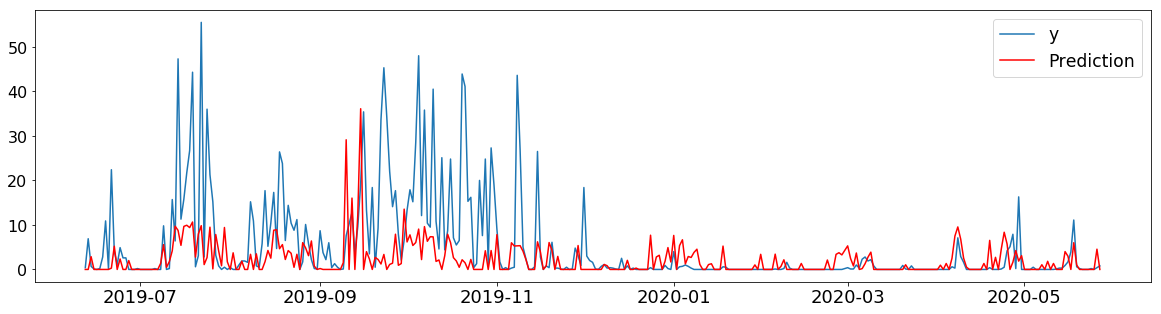

In [13]:
plt.figure(figsize=(20, 5))
plt.plot(prophet_test['ds'], prophet_test['y'])
plt.plot(df_predict.index, df_predict['Prediction'], color='r')
plt.legend(loc='best', fontsize='xx-large')
plt.xticks(fontsize=18)
plt.yticks(fontsize=16)
plt.show()

In [15]:
dataset=[]
df_series=pd.DataFrame(df_prophet['ds'].values,columns=['ds'])
for item in df_prophet.columns[2:]:
    df_series['y']=df_prophet[item].values
    model = Prophet(daily_seasonality=True)
    model.fit(df_series)
    future = model.make_future_dataframe(periods=45)
    forecast_future=model.predict(future)
    forecast_future_new=forecast_future[['ds', 'yhat']]
    forecast_future_new.columns=["ds",item]
    forecast_future_new[item]=[0.0 if w<0 else w for w in forecast_future_new[item].values]
    dataset.append(forecast_future_new)    

In [51]:
#Combine and create dataset for future prediction
dataset_final=pd.concat(dataset,axis=1)
dataset_final=dataset_final.iloc[:,[0,1,3,5,7,9,11]]
dataset_final=dataset_final.loc[dataset_final["ds"]>"2020-05-27"].reset_index(drop=True)

In [52]:
#create lag features on this
#create lag steps
lag_steps=8
df_lag=series_to_seq(dataset_final.iloc[:,1:],lag_steps)
#remove dates with nan values to concat
end=dataset_final.shape[0]-df_lag.shape[0]
df_lag = df_lag.set_index(dataset_final.index[:-end])
dataset_lagged = pd.concat([dataset_final.iloc[:-end,0:1], df_lag], axis=1)
dataset_lagged.head()

,ds,var1(t-8),var2(t-8),var3(t-8),var4(t-8),var5(t-8),var6(t-8),var1(t-7),var2(t-7),var3(t-7),...,var3(t-1),var4(t-1),var5(t-1),var6(t-1),var1(t),var2(t),var3(t),var4(t),var5(t),var6(t)
0,2020-05-28,1007.011849,43.268128,59.022609,33.448451,23.677326,15.012302,1007.011029,44.364258,60.143345,...,63.700070,32.377770,22.726188,18.353217,1007.241119,48.111356,64.333305,32.210612,22.565042,18.589004
1,2020-05-29,1007.011029,44.364258,60.143345,33.272572,23.537111,15.132381,1007.127646,46.319178,60.885919,...,64.333305,32.210612,22.565042,18.589004,1007.419448,49.076147,64.559746,31.973831,22.336031,19.194554
2,2020-05-30,1007.127646,46.319178,60.885919,33.021573,23.322712,15.649467,1007.147275,46.483038,61.271166,...,64.559746,31.973831,22.336031,19.194554,1007.494456,48.264858,64.411044,31.967228,22.120757,19.716306
3,2020-05-31,1007.147275,46.483038,61.271166,32.996032,23.115461,16.111581,1007.128294,46.831080,61.800245,...,64.411044,31.967228,22.120757,19.716306,1007.523888,47.674084,64.399312,31.520115,21.853304,20.265770
4,2020-06-01,1007.128294,46.831080,61.800245,32.526064,22.849277,16.631340,1007.129792,45.221449,62.490828,...,64.399312,31.520115,21.853304,20.265770,1007.566320,45.182038,64.553031,31.661956,21.735560,21.087516


In [53]:
#Train on full dataset
m = Prophet(changepoint_prior_scale=1.0, changepoint_range = 1.0,
                  interval_width=0.95, mcmc_samples=15,
                  daily_seasonality=True, weekly_seasonality=True, 
                  yearly_seasonality=True)

m.add_seasonality(name='monthly', period=30.5, fourier_order=4,mode='additive')

#except 'ds' & 'y' add all other columns as regressor
for i in range(2,len(df_prophet_lagged.columns)):
       m.add_regressor(df_prophet_lagged.columns[i])



m.fit(df_prophet_lagged)
forecastfinalpred=m.predict(dataset_lagged)

In [54]:
df_predict=forecastfinalpred[['ds', 'yhat']]
df_predict.columns=["Date","Prediction"]
#Adjust for -ve values
df_predict['Prediction']=[0.0 if w<0 else w for w in df_predict['Prediction'].values]
df_predict.Date = pd.to_datetime(df_predict.Date)
df_predict = df_predict.set_index("Date")

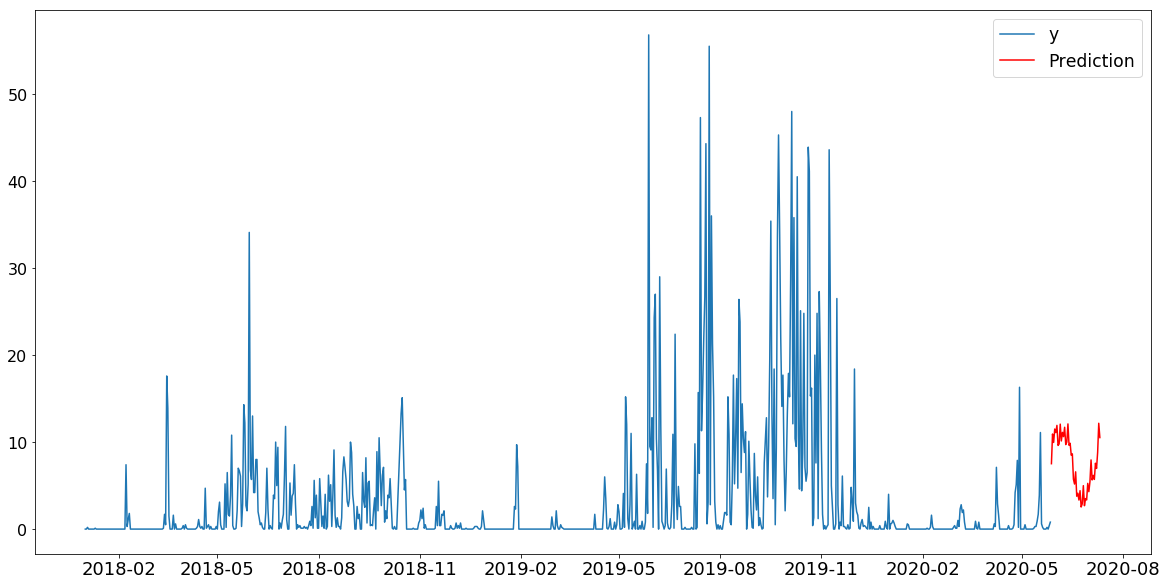

In [59]:
plt.figure(figsize=(20, 10))
plt.plot(df_prophet_lagged['ds'], df_prophet_lagged['y'])
plt.plot(df_predict.index, df_predict['Prediction'], color='r')
plt.legend(loc='best', fontsize='xx-large')
plt.xticks(fontsize=18)
plt.yticks(fontsize=16)
plt.show()